In [26]:
import torch, torchvision, PIL, numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
from tqdm.auto import tqdm
import pandas as pd
import pdb

In [33]:
# You can get more datasets here https://repository.cloudlab.zhaw.ch/artifactory/deepscores/archives/2017/
!wget https://tuggeluk.github.io/class_names/class_names_extended.csv
!wget https://repository.cloudlab.zhaw.ch/artifactory/deepscores/ds_extended.zip


--2021-03-27 01:37:27--  https://tuggeluk.github.io/class_names/class_names_extended.csv
Resolving tuggeluk.github.io (tuggeluk.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to tuggeluk.github.io (tuggeluk.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2566 (2.5K) [text/csv]
Saving to: ‘class_names_extended.csv’

class_names_extende 100%[===================>]   2.51K  --.-KB/s    in 0s      

2021-03-27 01:37:27 (56.0 MB/s) - ‘class_names_extended.csv’ saved [2566/2566]

--2021-03-27 01:37:27--  https://repository.cloudlab.zhaw.ch/artifactory/deepscores/ds_extended.zip
Resolving repository.cloudlab.zhaw.ch (repository.cloudlab.zhaw.ch)... 160.85.254.254
Connecting to repository.cloudlab.zhaw.ch (repository.cloudlab.zhaw.ch)|160.85.254.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 860045718 (820M) [application/zip]
Saving to: ‘ds_extended.zip.1’

ds_extended.zip.1    1

In [ ]:
!unzip ds_extended.zip -d music_dataset/

In [34]:
class_hashtable = {}
datasetHash = pd.read_csv('/content/class_names_extended.csv')
for i in range(len(datasetHash)):
  class_hashtable[datasetHash['brace'][i]] = datasetHash['0'][i]

In [142]:
class ObjectDetectionDataset:
    def __init__(self, root_dir, transform=None, transform_label=None):
        from os import walk 
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label
        def parse_box_and_class(line, class_num):
          line = line.replace(']', '').replace('[', '')
          x_min, x_max, y_min, y_max = line.split()
          return [int(class_num), float(x_min), float(y_min), float(x_max), float(y_max)]
        fileList = [] # Get the names of all the files in the root directory
        # Get all the csv files from meta_info
        labels = []
        for (dirpath, dirnames, filenames) in walk(root_dir):
          for name in filenames:
            if name.endswith('.csv'):
              f = dirpath + '/' + name
              fileList.append((name,f))
        # Now iterate through the fileList
        for name, file_name in fileList: 
          df = pd.read_csv(file_name)
          for i in range(1, len(df.index)):
            img_filename = df['file_name'][i].replace('.svg', '') + '.png'
            music_symbol = name.replace('.csv', '')
            if music_symbol in class_hashtable:
              labels.append((img_filename, parse_box_and_class(df['bbox'][i], class_hashtable[music_symbol])))    
        self.fns_labels = labels

    def __len__(self):
        # return the length of the dataset
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        # read the image from PILLOW library
        img = PIL.Image.open('music_dataset/deep_scores_dense_extended/images_png/' + imgfn)
        if self.transform:
            # apply the transform to the image if it exists!
            img = self.transform(img)
        #if self.transform_label:
            # same with the label, transform it! 
        #    label = self.transform_label(label)
        return (img, label)

In [132]:
def biggest_box_class(labels):
    pass
def biggest_box(labels):
    pass

In [133]:
dataset_dir = 'music_dataset/deep_scores_dense_extended/meta_info'

In [156]:
def show_img(img, title=None):
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    if title:
        plt.title(title) # add color='w' arg if using a dark background
    plt.axis('off')

# show the image with the class title 
def show_img_class(sample, classes=None):
    img, c = sample
    if classes:
        c = classes[c]
    show_img(img, c)

def show_boxes(sample, classes=None):
    img, labels = sample
    show_img(img)
    ax = plt.gca()
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    isx, isy = xmax-xmin, ymax-ymin
    kls, cx, cy, sx, sy = labels
    print(labels)
    if classes:
      kls = classes[int(kls)]
    box = patches.Rectangle((cx,cy), sx - cx, sy - cy, 0)
    ax.add_patch(box)
    plt.text(xmin + isx * (sx - cx / 2), ymin + isy * (sy + cy / 2), kls, backgroundcolor='r', c='w')

In [143]:
xform = torchvision.transforms.ToTensor()
dataset_full_det = ObjectDetectionDataset(dataset_dir, transform=xform, transform_label=biggest_box)

In [136]:
class_hashtable_reversed = {}
datasetHash = pd.read_csv('/content/class_names_extended.csv')
for i in range(len(datasetHash)):
  class_hashtable_reversed[datasetHash['0'][i]] = datasetHash['brace'][i] 

[133, 0.78728919, 0.77361737, 0.79493266, 0.7801951]


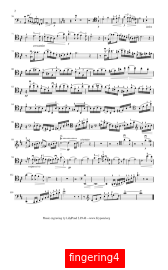

In [157]:
show_boxes(dataset_full_det[12], class_hashtable_reversed)

In [ ]:
n_all_det = len(SOMEDATASET)
n_used_det = int(1 * n_all_det)
n_train_det = int(0.8 * n_used_det)
n_test_det = n_used_det - n_train_det
rng_det = torch.Generator().manual_seed(291)
dataset_train_det, dataset_test_det, _ = torch.utils.data.random_split(SOMEDATASET, [n_train_det, n_test_det, n_all_det-n_train_det-n_test_det], rng_det)